### 1) Kernel

Pengolahan ini menggunakan kernel ais-tt atau saat ini: pyspark3.3 ais2.8 untuk melakukan pengolahan data. Kernel ini dilengkapi dengan konfigurasi spark tambahan dan kredensial untuk Amazon Web Services (AWS).

### 2) Mengaktifkan Sesi Spark

In [ ]:
#Sedona Imports
import sedona.sql
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.SpatialRDD import PolygonRDD, PointRDD
from sedona.core.enums import FileDataSplitter

import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql.types as pst
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType,LongType,StringType

In [ ]:
spark = SparkSession. \
    builder. \
    appName('Emissions_Indonesia'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages'). \
    config("spark.sql.execution.arrow.pyspark.enabled", "true").\
    config("spark.sql.parquet.enableVectorizedReader", "false").\
    getOrCreate()

SedonaRegistrator.registerAll(spark)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


Closing down clientserver connection


True

### 3) Read Data AIS di AWS S3 Bucket

In [ ]:
save_path = "s3a://ungp-ais-data-historical-backup/user_temp/"
save_path_unique = save_path + "212112081/"

In [ ]:
#read saved parquet
data = spark.read.parquet(save_path_unique + "ais-ihs-indonesia-2020_FULL.parquet", header=True)

### 4) Install seluruh package yang akan digunakan

In [ ]:
###Packages within Kernel by default
import geopandas as gpd
import h3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib as mpl
from shapely.ops import transform
from shapely.geometry import Polygon
from datetime import datetime
import requests

import pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame

import pandas as pd
import numpy as np
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import requests

generated new fontManager


### 5) Konversi Tipe Kapal ke ISIC 501 dan Assign Residensi

Ambil data dari GitHub

In [ ]:
convert_IHS = "https://raw.githubusercontent.com/GunturFai/ais-stis/main/Activities_Fix_1.csv"
convert_IHS = pd.read_csv(convert_IHS, sep=";")
convert_IHS = spark.createDataFrame(convert_IHS)

#Left Join berdasarkan ShipTypeLevel5
from pyspark.sql.functions import col
data = data.join(convert_IHS.select("ShiptypeLevel5", "Classif"), on="ShipTypeLevel5", how="left")
#data.printSchema()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


Filter data yang termasuk pada aktivitas ISIC 501 berdasarkan ShipTypeLevel5

In [ ]:
data_filtered = data.filter(col("Classif").isin("ISIC 501", "Fishing","Military")
#data_filtered2 = data_filtered.filter(col("OperatorCountryofDomicileName").isNotNull())

Rename Residensi
1.   Jika type = "res di luar" maka variabel Residensi memiliki nilai "Residen di Luar Teritory"
2.   Jika type = "res nonres di dalam" maka ada dua hal
*   Jika OperatorCountryofDomicile = Indonesia maka variabel Residensi = "Residen di Teritori"
*   Jika OperatorCountryofDomicile = Selain Indonesia maka variabel Residensi = "Nonresiden di Teritori"



In [ ]:
from pyspark.sql.functions import when

# Menambahkan variabel Residensi berdasarkan kondisi type dan OperatorCountryofDomicile
data = data_filtered2.withColumn("Residensi",
     when(col("tipe") == "res di luar", "Residen di Luar Teritory")
    .when((col("tipe") == "res nonres di dalam") & (col("OperatorCountryofDomicileName") == "Indonesia"), "Residen di Teritori")
    .when((col("tipe") == "res nonres di dalam") & (col("OperatorCountryofDomicileName") != "Indonesia"), "Nonresiden di Teritori")
)

In [ ]:
#Jumlah Record
#data.groupBy(col("Residensi")).count()

In [ ]:
dataframe = data.groupBy(col("Residensi")).count().toPandas()
print(dataframe)

                  Residensi      count
0    Nonresiden di Teritori  124842899
1       Residen di Teritori   49098390
2  Residen di Luar Teritory   21512685


## Koreksi akibat pengambilan data yang diperluas 1%

In [ ]:
h3_perluasan = spark.read.parquet(save_path_unique + "h3_index_level5_perluasan.parquet", header=True)

In [ ]:
#data inner
data_inner = data.filter(data['Residensi'] != 'Residen di Luar Teritory')
#Inner Join untuk mendapat data yang berada di area perluasan 1%
data_matched_inner = data_inner.join(h3_perluasan, data_inner.H3_int_index_5 == h3_perluasan.h3_index, "inner")

In [ ]:
count = data_matched_inner.count()
df_count_inner = pd.DataFrame({"Total Rows": [count]})
print(df_count_inner)

   Total Rows
0    58678307


In [ ]:
dataframematched = data_matched_inner.filter(data_matched_inner['Residensi'] == 'Residen di Teritori').count()
df_matched = pd.DataFrame({"Total Rows": [dataframematched]})
print(df_matched)

   Total Rows
0     1490477


In [ ]:
#data residen di perluasan 1% untuk tambahan residen outside
tambahan_res_out = data_matched_inner.filter(data_matched_inner['Residensi'] == 'Residen di Teritori')
tambahan_res_out = tambahan_res_out.drop('h3_index')
#data residen outside
data_resout = data.filter(data['Residensi'] == 'Residen di Luar Teritory')
#data corrected
data_residen_outside_corrected = data_resout.union(tambahan_res_out)

In [ ]:
#koreksi residen inside
data_residen_inside = data.filter(data['Residensi'] == 'Residen di Teritori')
data_residen_inside_corrected = data_residen_inside.subtract(tambahan_res_out)

In [ ]:
#koreksi nonresiden inside
data_nonresiden_di1perc = data_matched_inner.filter(data_matched_inner['Residensi'] == 'Nonresiden di Teritori')
data_nonresiden_di1perc = data_nonresiden_di1perc.drop('h3_index')
data_nonresiden_inside = data.filter(data['Residensi'] == 'Nonresiden di Teritori')
data_nonresiden_corrected = data_nonresiden_inside.subtract(data_nonresiden_di1perc)

In [ ]:
#Union All
#rename kolom baru
from pyspark.sql.functions import lit
data_residen_outside_corrected = data_residen_outside_corrected.withColumn("newres", lit("Residen Outside"))
data_residen_inside_corrected  = data_residen_inside_corrected.withColumn("newres", lit("Residen Inside"))
data_nonresiden_corrected = data_nonresiden_corrected.withColumn("newres", lit("Nonresiden Inside"))

#Union
dataunion1 = data_residen_outside_corrected.union(data_residen_inside_corrected)
dataunion2 = dataunion1.union(data_nonresiden_corrected)

In [ ]:
cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))

imo_filter = dataunion2.groupBy("imo")\
                .agg(F.count('dt_pos_utc').alias("count_ais"),
                    cnt_cond(F.col('sog') > 3). alias("count_min_sog"))\
                .where((F.col('count_ais') < 10)|(F.col('count_min_sog') < 20))\
                .select("imo")

In [ ]:
## jumlah kapal yang tidak aktif
#imo_filter.count()
imo_filter_list = imo_filter.select("imo")

data_filtered = dataunion2.join(imo_filter_list, on="imo", how="inner")

In [ ]:
#jumlah pesan yang diasumsikan kapalnya tidak aktif
data_filtered.count()

222901

In [ ]:
#pesan dengan kapal aktif
data_kapal_aktif = dataunion2.join(imo_filter_list, on="imo", how="left_anti")
data_less4 = data_kapal_aktif.filter(F.col("freq")<4)

In [ ]:
#jumlah pesan lebih dari 4 jam
data_more4 = data_kapal_aktif.filter(F.col("freq")>=4)
data_more4.count()

611230

In [ ]:
#union dulu
map_vessel_type = "https://raw.githubusercontent.com/nandyarz/ais/main/map_vessel_type_imo4.json"
map_vessel_type = spark.createDataFrame(pd.read_json(map_vessel_type))

df_merged = data_less4.alias("a").join(
    map_vessel_type.alias("b"),
    F.col("a.ShiptypeLevel5") == F.col("b.ShiptypeLevel5"),
    "left").select( "a.*", "b.StandardVesselType")

vessel_count = (
    df_merged.groupBy("StandardVesselType")
    .agg(F.countDistinct("imo").alias("total_vessels")))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


In [ ]:
vessel_count.show(19)

+--------------------+-------------+
|  StandardVesselType|total_vessels|
+--------------------+-------------+
|        Bulk carrier|         8189|
|Other liquids tan...|            8|
| Miscellaneous-other|          121|
|              Cruise|           88|
|Miscellaneous-fis...|           51|
|      Ferry-pax only|          220|
|               Ro-Ro|          211|
|       General cargo|          173|
|Liquified gas tanker|         1027|
|   Refrigerated bulk|          179|
|         Ferry-RoPax|            3|
|           Container|         2416|
|     Chemical tanker|         2088|
|             Vehicle|          520|
|          Oil tanker|         3137|
+--------------------+-------------+



## Preprocessing data IHS

In [ ]:
## mendapatkan kapal unik
datanew = data_less4
unique_vessel = datanew.dropDuplicates(["imo"])

### 1) Pengecekan Nilai Null pada variabel di IHS dan AIS

In [ ]:
#null pada sog/draught
columns_AIS = ['sog','draught','GrossTonnage', 'Deadweight',
           'DateOfBuild', 'TEU', 'Powerkwmax', 'MainEngineModel', 'Speed', 'Speedmax', 'SummerDraught', 'FuelType1Capacity',
           'FuelType2Capacity', 'MainEngineRPM', 'MainEngineType', 'PropulsionType', 'ShiptypeLevel5', 'OperatorCountryOfDomicileName']
#sampel 5%
datanew([
    F.count(F.when(F.col(c).isNull() | (F.col(c) == 0), 1)).alias(c)  # hitung null atau 0
    for c in columns_AIS
]).show(vertical=True)

### 2) Penyesuaian Spesifikasi Kapal Sesuai IMO GHG 4

In [ ]:
headers = {'User-Agent': 'XY'}

map_vessel_type = "https://raw.githubusercontent.com/nandyarz/ais/main/map_vessel_type_imo4.json"
map_vessel_type = pd.read_json(map_vessel_type)

#Types Table
vessel_type = "https://raw.githubusercontent.com/nandyarz/ais/main/type_table.json"
vessel_type = pd.read_json(vessel_type)

#####Functions--------------------
##Cleaning punctuations from new ais_types
def clean_string(text):
    text=''.join([word for word in text if word not in string.punctuation])
    text=text.lower()

    return text

##base shiptypelevel5 to comapre to
base_stype=map_vessel_type.ShiptypeLevel5.unique().tolist()

##Compare similiraty higher than 50% and return respective shiptype5 value
def compare_similarity(text):
    comp=[text]+base_stype
    cleaned=list(map(clean_string,comp))
    vectors=CountVectorizer().fit_transform(cleaned)
    vectors=vectors.toarray()
    csim=cosine_similarity(vectors)

    val_com=np.max(csim[0,1:])

    if val_com>0.75:
        v_type=base_stype[np.argmax(csim[0,1:])]
    else:
        v_type=None

    return v_type

##Imo bin finder
def bin_finder(vessel_t,value,df_in):
    try:
        bin_imo=df_in[((df_in.StandardVesselType==vessel_t)&(df_in.mindiff<=value)&(df_in.maxdiff>=value))].imo4bin.iloc[0]
    except:
        bin_imo=0
    return bin_imo

def ihs_preprocessing(df):
    columns = ['Powerkwmax', 'Speed', 'Speedmax', 'SummerDraught', 'MainEngineRPM']

    for c in columns:
        df[c].replace(0, np.nan, inplace=True)
        df[c]=df.groupby(["StandardVesselType", "imobin"])[c].apply(lambda x:x.fillna(x.mean()))
    return df

###++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
###Unit of cargo measurement per vessel type
unit={'Bulk carrier':'Deadweight',
     'Chemical tanker':'Deadweight',
     'Container':"TEU",
     'General cargo':'Deadweight',
     'Liquified gas tanker':'GrossTonnage',
     'Oil tanker':'Deadweight',
     'Other liquids tankers':'Deadweight',
     'Ferry-pax only':'GrossTonnage',
     'Cruise':'GrossTonnage',
     'Ferry-RoPax':'GrossTonnage',
     'Refrigerated bulk':'Deadweight',
     'Ro-Ro':'Deadweight',
     'Vehicle':'GrossTonnage',
     'Yacht':'GrossTonnage',
     'Service-tug':'GrossTonnage',
     'Miscellaneous-fishing':'GrossTonnage',
     'Offshore':'GrossTonnage',
     'Service-other':'GrossTonnage',
     'Miscellaneous-other':'GrossTonnage'}

##Engine type allocation
oil_eng=['Diesel-Elec & Gas Turbine(s)','Oil Engs & Fuel Cell-Electric''Oil Eng(s), Elec-Dr, Aux Sail','Oil Engines, Geared & Elec. Dr','Oil Eng(s) & Gas Turb(s) El.Dr','Oil Eng(s) Direct Dr, Aux Sail','Oil Eng(s) Dd & Gas Turb(s) El','Oil Engines, F&S, Geared Drive','Oil Engines, Direct & Elec. Dr','Oil Engines, Elec. & Direct Dr','Oil Engine(s), Drive Unknown','Oil Engines, Elec. & Geared Dr','Oil Eng(s), Geared, Aux Sail','Oil Engs & Gas Turb(s), Geared','Oil Engine(s), Electric Drive','Oil Engine(s), Direct Drive','Oil Engine(s), Geared Drive']
sail=['Sail, Aux Petrol Eng(s) D.Dr.','Sail, Aux Oil Eng(s), Elec Dr.','Sail, Aux Oil Eng(s), Geared','Sail','Sail, Aux Oil Eng(s) Direct-Dr',]
gas_tur=['Gas Turbine(s), Electric Drive','Gas Turbine(s) Or Diesel Elec.','Gas Turbine(s) & Diesel Elec.','Gas Turbine(s), Geared Drive',]
steam=['S.Turb, Gear & Oil Eng(s), Ele','St. Turb(s) Elec Dr. Or D.E.','Steam Turbine(s), Direct Drive','Steam Recip(s) With Lp Turbine','Steam Turbine(s), Elec.Drive','Steam- & Gas-Turbines, Geared','Steam Turbine(s), Geared Drive','Steam Recip(s), Direct Drive',]


def adapted_specs_imo(df_unique_imo):
    df_unique_imo.rename(columns={"vessel_type_main":"ais_type","length":"ais_loa","width":"ais_beam"},inplace=True)

    ind=df_unique_imo.copy()

    ind=ind.assign(ShiptypeLevel5=np.where(ind.ShiptypeLevel5.isnull(),ind.ais_type,ind.ShiptypeLevel5))
    ##Remove values with Shiptypelevel5 null. Not much else to do with this records.
    ##Remove nans before similarity check
    ind=ind[ind.ShiptypeLevel5.notnull()]
    ind=ind.assign(ShiptypeLevel5=np.where(ind.ShiptypeLevel5.isin(base_stype),ind.ShiptypeLevel5,
                                           ind.ShiptypeLevel5.apply(lambda x: compare_similarity(x))))
    ##Ensure no vessel without Standard vessel type
    ind=ind[ind.ShiptypeLevel5.notnull()]

    ##---Pending----Inputation here input from AIS(Length,Beam) and Shiptypelevel5 to have [DWT,GT]. Potential RF Regressor (missForest).

    ind=pd.merge(ind,map_vessel_type,how="left",on='ShiptypeLevel5')

    ind=ind.assign(imobin=ind.apply(lambda x: bin_finder(x.StandardVesselType,x[unit[x.StandardVesselType]],vessel_type),axis=1))

    ind=ihs_preprocessing(ind)

    ###Fuel allocation
    ind=ind.assign(fuel=np.where(((ind.FuelType1First=='Residual Fuel')|(ind.FuelType2Second=='Residual Fuel')),
                                np.where(((ind.PropulsionType.isin(['Steam Turbine(s), Geared Drive','S.Turb, Gear & Oil Eng(s), Ele','Steam Recip(s), Direct Drive','Steam- & Gas-Turbines, Geared','Steam Turbine(s), Elec.Drive','Steam Recip(s) With Lp Turbine','Steam Turbine(s), Direct Drive','St. Turb(s) Elec Dr. Or D.E.',]))\
                                                                &(ind.StandardVesselType=='Liquified gas tanker')),"LNG","HFO"),
                                    np.where(((ind.FuelType1First=='Distillate Fuel')&(ind.FuelType2Second=='Distillate Fuel')),"MDO",
                                    np.where(((ind.FuelType1First=='Distillate Fuel')&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),"MDO",
                                    np.where(((ind.FuelType1First.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))&(ind.FuelType2Second=='Distillate Fuel')),"MDO",
                                    np.where(((ind.FuelType1First=='Coal')&(ind.FuelType2Second=='Distillate Fuel')),"MDO",
                                    np.where(((ind.FuelType1First=='Methanol')&(ind.FuelType2Second=='Distillate Fuel')),'Methanol',
                                        np.where((((ind.FuelType1First=='Residual Fuel')|(ind.FuelType2Second=='Residual Fuel'))&\
                                                ((ind.StandardVesselType=='Liquified gas tanker')&(ind.PropulsionType.isin(['Steam Turbine(s), Geared Drive','S.Turb, Gear & Oil Eng(s), Ele','Steam Recip(s), Direct Drive','Steam- & Gas-Turbines, Geared','Steam Turbine(s), Elec.Drive','Steam Recip(s) With Lp Turbine','Steam Turbine(s), Direct Drive','St. Turb(s) Elec Dr. Or D.E.',])))),'LNG',
                                        np.where(((ind.FuelType1First=='Gas Boil Off')&(ind.FuelType2Second=='Distillate Fuel')),'LNG',
                                        np.where(((ind.FuelType1First.isin(["LNG",'Lpg','Lng']))&(ind.FuelType2Second=='Distillate Fuel')),'LNG',
                                        np.where(((ind.FuelType1First.isin(["LNG",'Lpg','Lng']))&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),'LNG',
                                        np.where(((ind.FuelType1First.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))&(ind.FuelType2Second.isin(["LNG",'Lpg','Lng']))),'LNG',
                                        np.where(ind.FuelType2Second=='Gas Boil Off','LNG',
                                            np.where(((ind.FuelType1First=='Nuclear')&(ind.FuelType2Second=='Distillate Fuel')),'Nuclear',
                                            np.where(((ind.FuelType1First=='Nuclear')&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),'Nuclear',
                                                    np.where(((ind.FuelType1First=='Coal')&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),'Coal',
                                                            np.where(ind.FuelType1First=='Methanol','Methanol',
                                None))))))))))))))))
                )


    ###Engine types
    ind=ind.assign(meType=np.where(ind.PropulsionType.isin(oil_eng),
                                np.where(ind.MainEngineRPM<=300,"SSD",
                                np.where(ind.MainEngineRPM.between(301,900),"MSD",
                                np.where(ind.MainEngineRPM>900,"HSD","SSD"))),
                        np.where(ind.PropulsionType.isin(['Petrol Engine(s), Direct Drive','Petrol Engine(s), Geared Drive']),"HSD",
                        np.where(ind.PropulsionType.isin(sail),"Sail",
                        np.where(ind.PropulsionType=='Battery-Electric',"Batteries",
                        np.where(ind.PropulsionType=='Non-Propelled','Non-Propelled',
                        "SSD"))))))

    ind=ind.assign(meType=np.where(ind.fuel=="LNG",
                                np.where(((ind.MainEngineModel.str.contains("X"))|(ind.MainEngineModel.str.contains("DF"))),"LNG-Otto-SS",
                                np.where(ind.MainEngineRPM>300,"LNG-Otto-MS",
                                np.where(ind.MainEngineModel.str.contains("ME"),"LNG-Diesel","LNG-Otto-MS"
                                ))),
                            np.where(ind.fuel=="Methanol","Methanol",
                                ind.meType)))


    ##Gas turbines and Steam turbines conditional on former filters
    ind=ind.assign(meType=np.where(((ind.PropulsionType.isin(gas_tur))|(((ind.meType.isin(["SSD","MSD"]))&(ind.fuel=="Gas")))),"Gas Turbine",
                        np.where(ind.PropulsionType.isin(steam),"Steam Turbine",
                        ind.meType
                    ))
                )
    ind=ind.assign(fuel=np.where(ind.meType=="Sail","Sail",
                        np.where(ind.meType=="Non-Propelled","Non-Propelled",
                        np.where(((ind.fuel.isnull())&(ind.meType=="HSD")),"MDO",
                        np.where(((ind.fuel.isnull())&(ind.meType=="MSD")),"MDO",
                        np.where(((ind.fuel.isnull())&(ind.meType=="SSD")),"HFO",
                                ind.fuel)))))
                )

    ind=ind[['imo','mmsi', 'vessel_name', 'GrossTonnage', 'Deadweight', 'LengthOverallLOA',
    'DateOfBuild', 'TEU', 'Powerkwmax', 'MainEngineModel', 'Speed', 'Speedmax', 'Speedservice', 'BreadthExtreme', 'SummerDraught', 'FuelType1Capacity',
    'FuelType2Capacity', 'LightDisplacementTonnage', 'MainEngineRPM', 'MainEngineType', 'Powerkwservice', 'PropulsionType',
    'TotalBunkerCapacity', 'StandardVesselType', 'imobin', 'fuel', 'meType','ais_beam','ais_loa']]

    return ind

In [ ]:
specs = spark.createDataFrame(adapted_specs_imo(unique_vessel.toPandas()))

/tmp/ipykernel_51/686847137.py:51: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[c]=df.groupby(["StandardVesselType", "imobin"])[c].apply(lambda x:x.fillna(x.mean()))
/tmp/ipykernel_51/686847137.py:51: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[c]=df.groupby(["StandardVesselType", "imob

In [ ]:
columns = ['Powerkwmax', 'Speed', 'Speedmax', 'SummerDraught', 'MainEngineRPM']

specs.select([F.count(F.when((F.col(c)==0)|(F.col(c).isNull()), c)).alias(c) for c in columns]).show(vertical=True)

-RECORD 0------------
 Powerkwmax    | 0   
 Speed         | 0   
 Speedmax      | 0   
 SummerDraught | 0   
 MainEngineRPM | 0   



### 3) Penggabungan Data AIS dan Spesifikasi IHS

In [ ]:
df = datanew.select("imo","draught","sog","dt_pos_utc","freq","longitude","latitude", "newres").join(specs,["imo"], how="inner")

### 4) Pengisian nilai null dan default pada data AIS: draught dan sog

In [ ]:
# Menampilkan banyaknya record dengan draught = 0 (default)
#df.select("draught").filter(F.col("draught")==0).count()

17637135

In [ ]:
# Fungsi untuk mengisi nilai null dan default
def infill(dfspark):
    w1 = Window.partitionBy('imo').orderBy('dt_pos_utc')
    w2 = w1.rowsBetween(0, Window.unboundedFollowing)

    dfspark = dfspark.withColumn("dt_pos_utc_unix", F.unix_timestamp(F.col("dt_pos_utc")))
    dfspark = dfspark.withColumn("dt_pos_utc_null", F.when(F.col("draught")==0, None).otherwise(F.col("dt_pos_utc_unix"))) \
                        .withColumn("draught_null", F.when(F.col("draught")==0, None).otherwise(F.col("draught")))
    dfspark = dfspark.withColumn("dt_pos_utc_diff", (F.lit(2)*F.col("dt_pos_utc_unix")-F.last('dt_pos_utc_null',True).over(w1)-F.first('dt_pos_utc_null',True).over(w2)))

    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("dt_pos_utc_diff")<=0, F.last('draught_null',True).over(w1)).otherwise(F.first('draught_null',True).over(w2)))
    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill").isNull(), F.first('draught_null',True).over(w2)).otherwise(F.col("draught_fill")))

    w1 = Window.partitionBy(["StandardVesselType", "imobin"])
    w2 = Window.partitionBy()

    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill").isNull(), F.avg("draught_null").over(w1)).otherwise(F.col("draught_fill")))
    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill").isNull(), F.avg("draught_null").over(w2)).otherwise(F.col("draught_fill")))
    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill") > F.lit(1.5)*F.col("SummerDraught"), F.col("SummerDraught")).otherwise(F.col("draught_fill")))\
                        .withColumn("sog", F.when(F.col("sog") > F.col("SpeedMax"), F.col("SpeedMax")).otherwise(F.col("sog")))

    return dfspark.drop("dt_pos_utc_unix", "dt_pos_utc_null", "dt_pos_utc_diff", "draught_mean")

In [ ]:
# Menerapkan fungsi infill dan menghitung load = sog/Speed
df = infill(df).withColumn("load",F.col("sog")/F.col("Speed"))

### 6) Penentuan Fase Operasional

In [ ]:
# conditional rule pada fase operasional
def op_phase_assign(df):

    anch="Anchorage"
    berth="Berth"
    slow="Slow transit"
    normal="Normal cruising"
    man="Manoeuvring"

    df = df.withColumn("op_phase",
                      F.when(F.col("sog")<=1, berth).otherwise(
                      F.when(((F.col("sog")>1)&(F.col("sog")<=3)), anch).otherwise(
                      F.when(((F.col("sog")>3)&(F.col("sog")<=5)), man).otherwise(
                      F.when(((F.col("sog")>5)&(F.col("load")<=0.65)), slow).otherwise(
                      normal)
                      ))))


    return df

In [ ]:
# Menerapkan fungsi conditional rule
df = op_phase_assign(df)

# ESTIMASI POWER DEMAND

### AE AND AB

In [ ]:
ae_ab_power = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/01-ae_ab_power.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
df = df.withColumn("ae_power",F.when(F.col("Powerkwmax")<=150,0)
                                    .otherwise(F.when(F.col("Powerkwmax").between(151,500),F.lit(0.05)*F.col("Powerkwmax")*F.col("freq"))))\
        .withColumn("ab_power",F.when(F.col("Powerkwmax")<=150,0))

In [ ]:
df = df.join(ae_ab_power,["StandardVesselType","imobin"],"left")

In [ ]:
df = df.withColumn("ae_power",F.when(F.col("ae_power").isNull(),
                                                           F.when(F.col("op_phase").isin(["Slow transit","Normal cruising"]),F.col("ae_sea")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Berth",F.col("ae_berth")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Manoeuvring",F.col("ae_man")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Anchorage",F.col("ae_anch")*F.col("freq"))\
                                                           .otherwise(F.col("ae_sea")*F.col("freq"))))))\
                                           .otherwise(F.col("ae_power")))\
                                .withColumn("ab_power",F.when(F.col("ab_power").isNull(),
                                                           F.when(F.col("op_phase").isin(["Slow transit","Normal cruising"]),F.col("ab_sea")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Berth",F.col("ab_berth")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Manoeuvring",F.col("ab_man")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Anchorage",F.col("ab_anch")*F.col("freq"))\
                                                           .otherwise(F.col("ab_sea")*F.col("freq"))))))\
                                           .otherwise(F.col("ab_power")))

### ME

In [ ]:
weath_foul = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/11-correction_factor.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
df = df.join(weath_foul,["StandardVesselType","imobin"],"left")

df = df.withColumn("me_power",F.when(F.col("op_phase").isin(["Berth","Anchorage"]),0)\
                                           .otherwise(F.when(F.col("StandardVesselType")=="Cruise",
                                                      (F.lit(0.70)*F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling")))\
                                                      .otherwise(F.when(F.col("StandardVesselType")=="Container",
                                                                        F.when(F.col("imobin").isin([8,9]),
                                                                               (F.lit(0.75)*F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling")))\
                                                                        .otherwise((F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling"))))\
                                                                 .otherwise((F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling")))
                                                                )))
df = df.withColumn("me_power",F.col("me_power")*F.col("freq"))


# ESTIMASI FUEL CONSUMPTION

### SFOC ME

In [ ]:
me_sf = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/03-SFC_base.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
df = df.join(me_sf,["meType","fuel"],"left")

##Creates a column with Year of Build as an integer variable
df = df.withColumn("YearOfBuild",F.col("DateOfBuild").cast(StringType()).substr(1,4).cast(IntegerType()))

df = df.withColumn("sfc_me",F.when(F.col("meType").isin(["SSD","MSD","HSD"]),
                                                  F.when(F.col("YearOfBuild")<=1983,F.col("_83")*(F.lit(0.455)*(F.col("load")**2)-F.lit(0.710)*F.col("load")+F.lit(1.280)))\
                                                  .otherwise(F.when(F.col("YearOfBuild").between(1984,2000),F.col("84_2000")*(F.lit(0.455)*(F.col("load")**2)-F.lit(0.710)*F.col("load")+F.lit(1.280)))\
                                                  .otherwise(F.when(F.col("YearOfBuild")>=2001,F.col("2001_")*(F.lit(0.455)*(F.col("load")**2)-F.lit(0.710)*F.col("load")+F.lit(1.280)))\
                                                            )))\
                                           .otherwise(F.when(F.col("YearOfBuild")<=1983,F.col("_83"))\
                                           .otherwise(F.when(F.col("YearOfBuild").between(1984,2000),F.col("84_2000"))\
                                           .otherwise(F.when(F.col("YearOfBuild")>=2001,F.col("2001_"))))))

### SFOC AE AND AB

In [ ]:
ae_ab_sf = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/04-SFC_base_AE.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
ae_sf = ae_ab_sf.filter(F.col("meType")=="AB").drop("meType")
ab_sf = ae_ab_sf.filter(F.col("meType")=="AE").drop("meType")

In [ ]:
##AE
df = df.join(ae_sf,["fuel"],how="left")

df = df.withColumn("sfc_ae",F.when(F.col("YearOfBuild")<=1983,F.col("ae_ab_83"))\
                                           .otherwise(F.when(F.col("YearOfBuild").between(1984,2000), F.col("ae_ab_84_2000"))\
                                           .otherwise(F.when(F.col("YearOfBuild")>=2001, F.col("ae_ab_2001_"))\
                                           .otherwise(F.lit(0)))))


df = df.drop(*("ae_ab_83","ae_ab_84_2000","ae_ab_2001_"))

##AB
df = df.join(ab_sf,["fuel"],how="left")

df = df.withColumn("sfc_ab",F.when(F.col("YearOfBuild")<=1983,F.col("ae_ab_83"))\
                                           .otherwise(F.when(F.col("YearOfBuild").between(1984,2000), F.col("ae_ab_84_2000"))\
                                           .otherwise(F.when(F.col("YearOfBuild")>=2001, F.col("ae_ab_2001_"))\
                                           .otherwise(F.lit(0)))))

### FC

In [ ]:
df = df.withColumn("me_con",F.col("me_power")*F.col("sfc_me"))\
                               .withColumn("ae_con",F.col("ae_power")*F.col("sfc_ae"))\
                               .withColumn("ab_con",F.col("ab_power")*F.col("sfc_ab"))\
                               .withColumn("pilot_con",F.col("me_power")*F.col("pilot_mdo"))  ###Pilot MDO for LNG fuel

# ESTIMASI EMISI

## FUEL BASED

### CO2

In [ ]:
df = df.withColumn("pilot_con",F.when(F.col("pilot_con").isNull()|F.isnan(F.col("pilot_con")),0).otherwise(F.col("pilot_con")))
ef_co2 = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/21-EF_carbon.csv"))

df = df.join(ef_co2,["fuel"],"left")

df = df.withColumn("co2_g",F.col("me_con")*F.col("ef_co2")+\
                                            F.col("ae_con")*F.col("ef_co2")+\
                                            F.col("ab_con")*F.col("ef_co2")+\
                                            F.col("pilot_con")*F.lit(3.206))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


## ENERGY BASED

### CH4

In [ ]:
ef_ch4 = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/22-EF_methana.csv"))
ef_ch4_ae = ef_ch4.filter(F.col("meType")=="AE").drop("meType").withColumnRenamed("ef_ch4","ef_ch4_ae")
ef_ch4_ab = ef_ch4.filter(F.col("meType")=="AB").drop("meType").withColumnRenamed("ef_ch4","ef_ch4_ab")

df = df.join(ef_ch4,["meType","fuel"],"left")\
        .join(ef_ch4_ae,["fuel"],"left")\
        .join(ef_ch4_ab,["fuel"],"left")

##Low load factor
df = df.withColumn("ef_ch4",F.when(F.col("load")<0.02,F.lit(21.18))\
                                           .otherwise(F.when(F.col("load").between(0.02,0.1),2.18)\
                                           .otherwise(F.when(F.col("load").between(0.1001,0.2),1.0).otherwise(F.col("ef_ch4")))))


df = df.withColumn("ch4_g",F.col("me_power")*F.col("ef_ch4")+\
                                           F.col("ae_power")*F.col("ef_ch4_ae")+\
                                           F.col("ab_power")*F.col("ef_ch4_ab"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


### NO2

In [ ]:
ef_n2o = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/23-EF_nitrous_oxide.csv"))
ef_n2o_ae = ef_n2o.filter(F.col("meType")=="AE").drop("meType").withColumnRenamed("ef_n2o","ef_n2o_ae")
ef_n2o_ab = ef_n2o.filter(F.col("meType")=="AB").drop("meType").withColumnRenamed("ef_n2o","ef_n2o_ab")

df = df.join(ef_n2o,["meType","fuel"],"left")\
                                .join(ef_n2o_ae,["fuel"],"left")\
                                .join(ef_n2o_ab,["fuel"],"left")

##Low load factor
df = df.withColumn("ef_n2o",F.when(F.col("load")<0.02,F.lit(4.63))\
                                           .otherwise(F.when(F.col("load").between(0.02,0.1),F.lit(1.22))\
                                           .otherwise(F.when(F.col("load").between(0.1001,0.2),1.0).otherwise(F.col("ef_n2o")))))

df = df.withColumn("n2o_g",F.col("me_power")*F.col("ef_n2o")+\
                                           F.col("ae_power")*F.col("ef_n2o_ae")+\
                                           F.col("ab_power")*F.col("ef_n2o_ab"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
##Transform grams to tonnes
df=df.withColumn("co2_t",F.col("co2_g")*1e-6)\
        .withColumn("ch4_t",F.col("ch4_g")*1e-6)\
        .withColumn("n2o_t",F.col("n2o_g")*1e-6)

# VISUALISASI DAN RINGKASAN HASIL ESTIMASI

## Emission per ship type

In [ ]:
#Kode menghitung emisi sekali untuk tiap jenis kapal
vessel_emissions_ship = (
    df.filter(
        ~((F.isnan("co2_t") | F.col("co2_t").isNull()) |
          (F.isnan("ch4_t") | F.col("ch4_t").isNull()) |
          (F.isnan("n2o_t") | F.col("n2o_t").isNull()))
    )
    .groupBy("StandardVesselType")
    .agg(
        F.sum("co2_t").alias("total_co2"),
        F.sum("ch4_t").alias("total_ch4"),
        F.sum("n2o_t").alias("total_n2o")
    )
    .orderBy("StandardVesselType")  # Urut berdasarkan nama tipe kapal (A-Z)
)

In [ ]:
vessel_emissions_ship.show(19)

+--------------------+--------------------+--------------------+-------------------+
|  StandardVesselType|           total_co2|           total_ch4|          total_n2o|
+--------------------+--------------------+--------------------+-------------------+
|        Bulk carrier|1.3233728257972918E7|   239.0207880908956|  716.8916339770282|
|     Chemical tanker|   2858619.393633811|   40.32557300232867| 149.65375946391103|
|           Container|   6696131.591305465|  136.33293914069256| 346.82044764933744|
|              Cruise|   315084.5452229657|   3.583611435510546| 13.787555493895862|
|         Ferry-RoPax|  14190.544544143373|  0.1739330235222642| 0.6536324398565463|
|      Ferry-pax only|  452935.44618484785|   6.639447968701151|  21.23958252196732|
|       General cargo|  308728.65842450183|   4.109731691152425| 14.869902078540742|
|Liquified gas tanker|  3036853.5634652236|   5865.692461745556| 156.12231884392452|
|Miscellaneous-fis...|   2686.396748338402| 0.03648373682991062|0

## Heatmap per emission

In [ ]:
geo_to_h3 = F.udf(lambda latitude, longitude, resolution: h3.string_to_h3(h3.geo_to_h3(latitude,longitude, resolution)), LongType())

df_emission = df.withColumn("H3_int_index_6",geo_to_h3(F.col('latitude'),F.col("longitude"),F.lit(6)))\
                            .withColumn("totalEm", F.col("co2_t") + 21 * F.col("ch4_t") + 310 * F.col("n2o_t"))
df_plot = df_emission.groupby("H3_int_index_6","newres").agg({"totalEm": "sum"}) \
    .withColumn("log_totalEmission", F.log10(F.col("sum(totalEm)")))
df_plot = df_plot.toPandas()

Text(0.5, 891.4222222222226, '')

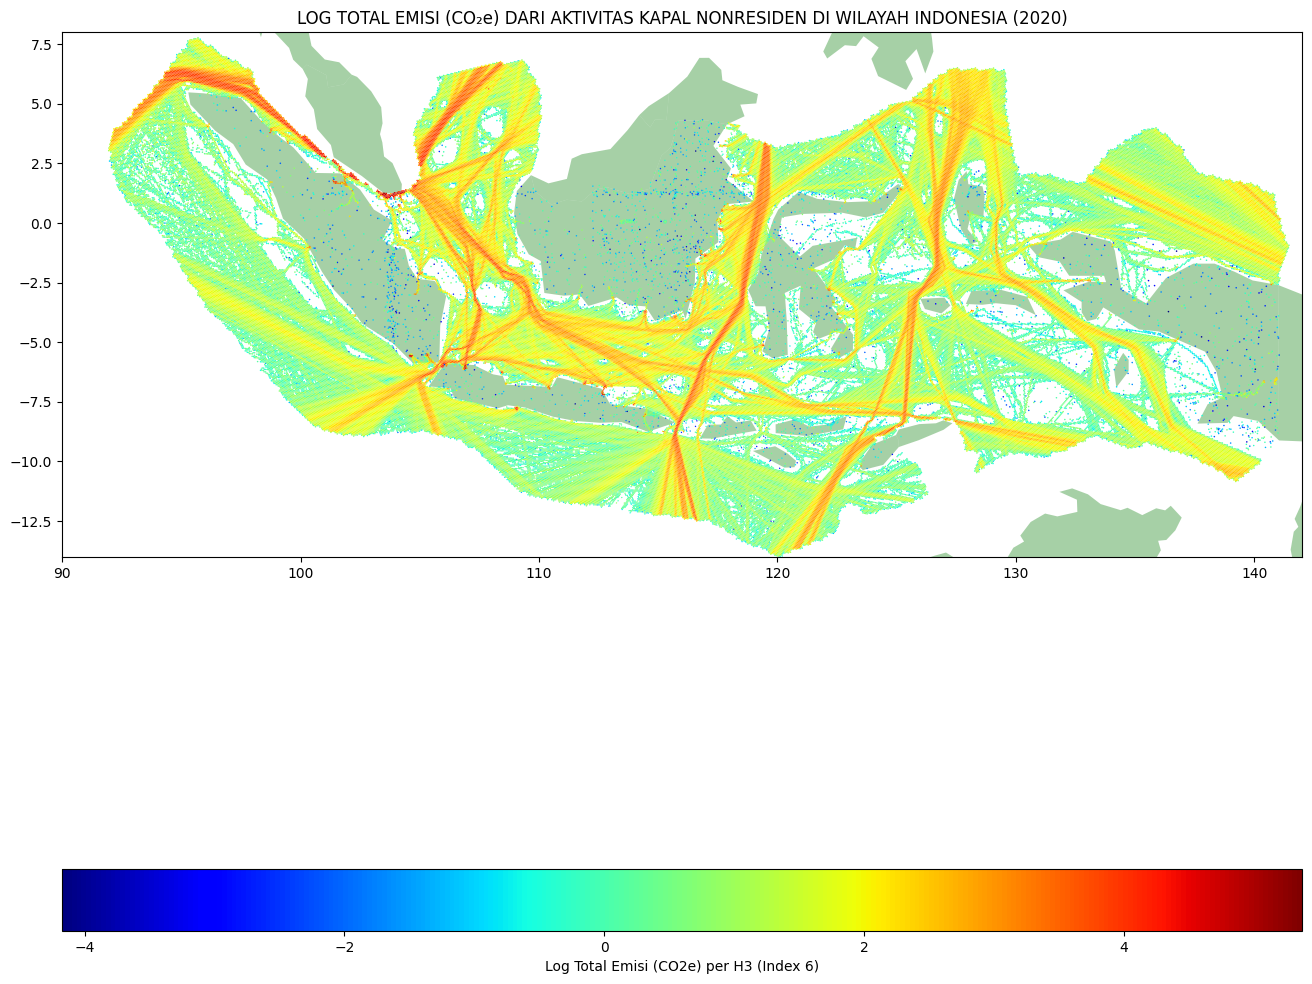

In [ ]:
# EMISI NONRESIDEN INSIDE

fig, ax1 = plt.subplots(figsize=(16,27))

cmap = mpl.cm.jet
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

df_plot_nonres = df_plot[df_plot["newres"] == "Nonresiden Inside"]

df_plot_nonres = df_plot_nonres.assign(hex_id=df_plot_nonres.H3_int_index_6.apply(lambda x: h3.h3_to_string(x)))
geom_h3=[]
for ind, row in df_plot_nonres.iterrows():
    geom=Polygon(h3.h3_to_geo_boundary(row["hex_id"], geo_json=True))
    geom_h3.append(geom)

df_plot_nonres = df_plot_nonres.assign(geometry=geom_h3)
df_plot_nonres = gpd.GeoDataFrame(df_plot_nonres,geometry="geometry")

countries.plot(ax=ax1, alpha=0.4, color="forestgreen")
df_plot_nonres.plot(ax=ax1,column='log_totalEmission',cmap=cmap, legend=True, legend_kwds = {'label': "Log Total Emisi (CO2e) per H3 (Index 6)", "orientation": "horizontal"})

ax1.set_xlim(90, 142)
ax1.set_ylim(-14, 8)

# chart formatting
ax1.set_title("LOG TOTAL EMISI (CO₂e) DARI AKTIVITAS KAPAL NONRESIDEN DI WILAYAH INDONESIA (2020)")
ax1.set_xlabel("")

Text(0.5, 891.4222222222226, '')

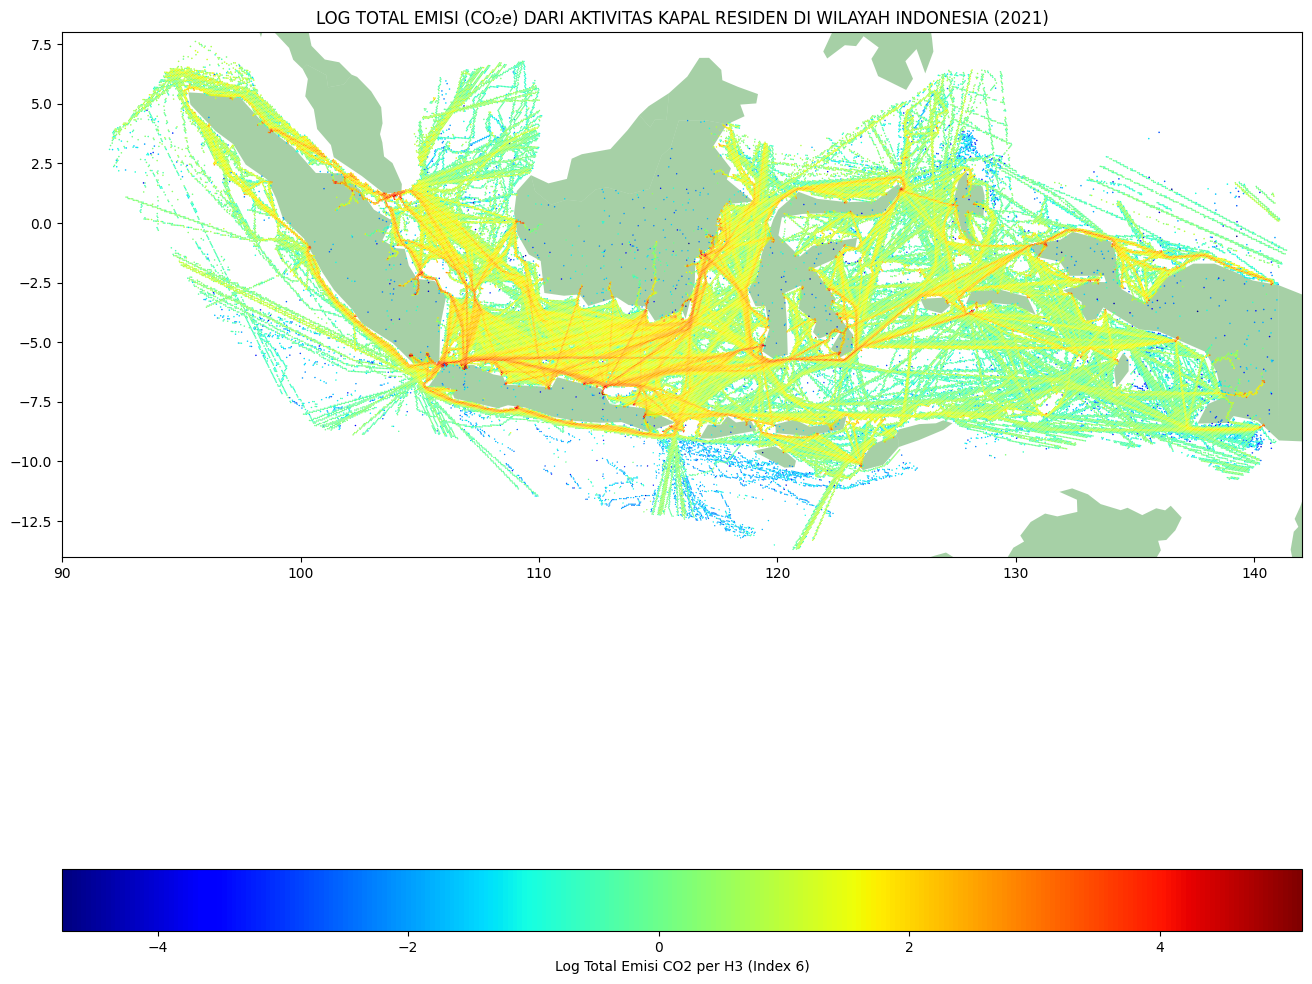

In [ ]:
#EMISI RESIDEN INSIDE

fig, ax2 = plt.subplots(figsize=(16,27))

cmap = mpl.cm.jet
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

df_plot_res = df_plot[df_plot["newres"] == "Residen Inside"]

df_plot_res = df_plot_res.assign(hex_id=df_plot_res.H3_int_index_6.apply(lambda x: h3.h3_to_string(x)))
geom_h3=[]
for ind, row in df_plot_res.iterrows():
    geom=Polygon(h3.h3_to_geo_boundary(row["hex_id"], geo_json=True))
    geom_h3.append(geom)

df_plot_res = df_plot_res.assign(geometry=geom_h3)
df_plot_res = gpd.GeoDataFrame(df_plot_res,geometry="geometry")

countries.plot(ax=ax2, alpha=0.4, color="forestgreen")
df_plot_res.plot(ax=ax2,column='log_totalEmission',cmap=cmap, legend=True, legend_kwds = {'label': "Log Total Emisi CO2 per H3 (Index 6)", "orientation": "horizontal"})

ax2.set_xlim(90, 142)
ax2.set_ylim(-14, 8)

# chart formatting
ax2.set_title("LOG TOTAL EMISI (CO₂e) DARI AKTIVITAS KAPAL RESIDEN DI WILAYAH INDONESIA (2021)")
ax2.set_xlabel("")

Text(0.5, 891.4222222222226, '')

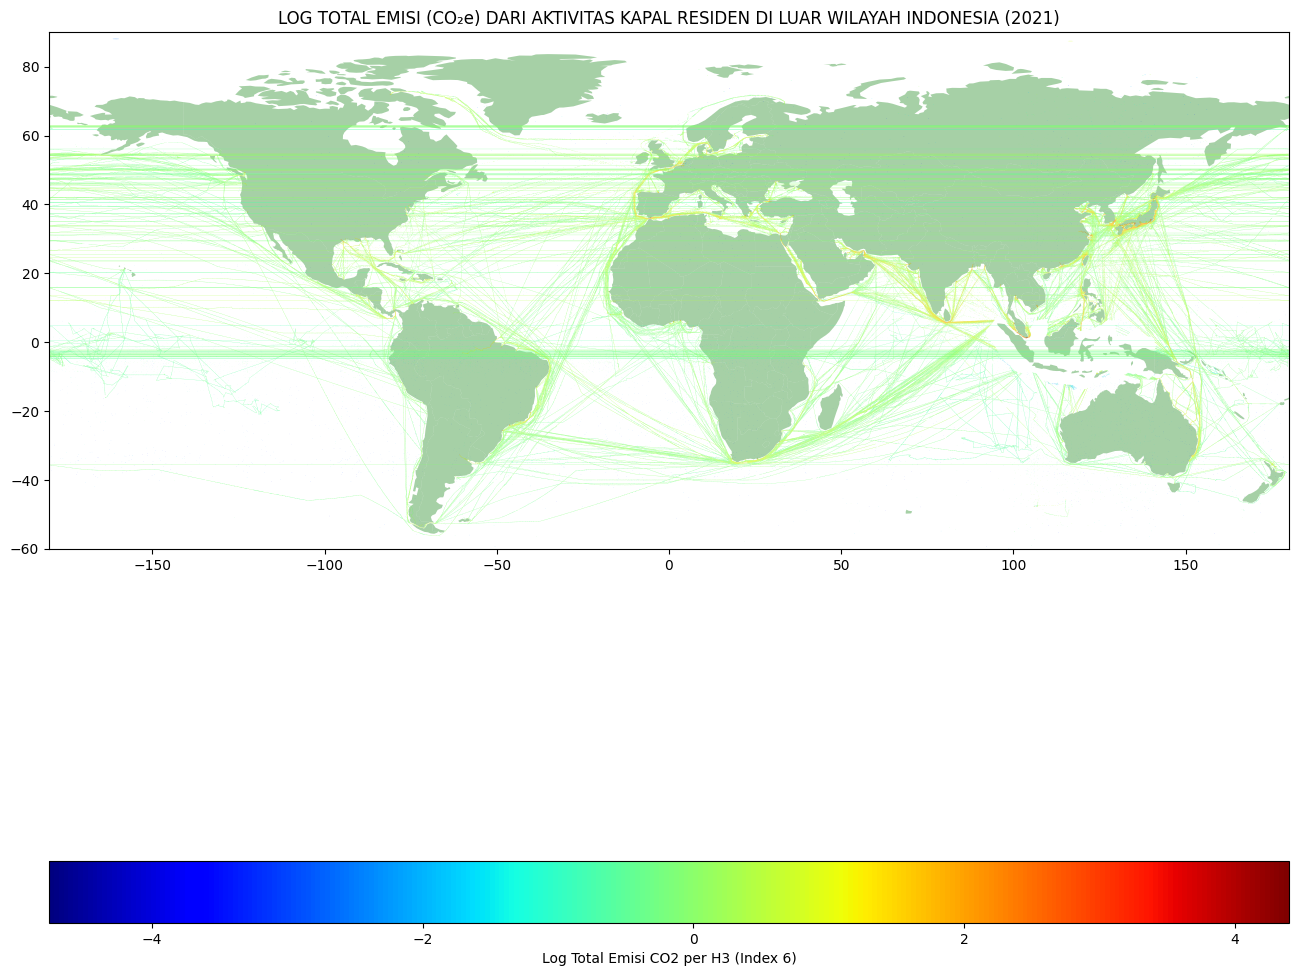

In [ ]:
#EMISI RESIDEN OUTSIDE

fig, ax3 = plt.subplots(figsize=(16,27))

cmap = mpl.cm.jet
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

df_plot_resout = df_plot[df_plot["newres"] == "Residen Outside"]

df_plot_resout = df_plot_resout.assign(hex_id=df_plot_resout.H3_int_index_6.apply(lambda x: h3.h3_to_string(x)))
geom_h3=[]
for ind, row in df_plot_resout.iterrows():
    geom=Polygon(h3.h3_to_geo_boundary(row["hex_id"], geo_json=True))
    geom_h3.append(geom)

df_plot_resout = df_plot_resout.assign(geometry=geom_h3)
df_plot_resout = gpd.GeoDataFrame(df_plot_resout,geometry="geometry")

countries.plot(ax=ax3, alpha=0.4, color="forestgreen")
df_plot_resout.plot(ax=ax3,column='log_totalEmission',cmap=cmap, legend=True, legend_kwds = {'label': "Log Total Emisi CO2 per H3 (Index 6)", "orientation": "horizontal"})

ax3.set_xlim(-180, 180)
ax3.set_ylim(-60, 90)

# chart formatting
ax3.set_title("LOG TOTAL EMISI (CO₂e) DARI AKTIVITAS KAPAL RESIDEN DI LUAR WILAYAH INDONESIA (2021)")
ax3.set_xlabel("")

## Emission per Month and Per Resident Type only on ISIC 501

In [ ]:
##Transform grams to tonnes
df = df.withColumn("date_pos",F.to_date("dt_pos_utc"))
df = df.where(df.date_pos > "2019-12-31")
df = df.withColumn('month_pos', F.month(df['date_pos']))

In [ ]:
vessel_emissions = (
    df.select("month_pos", "newres", "co2_t", "n2o_t", "ch4_t")
    .filter(
        ~(
            (F.isnan(F.col("co2_t")) | F.col("co2_t").isNull()) |
            (F.isnan(F.col("n2o_t")) | F.col("n2o_t").isNull()) |
            (F.isnan(F.col("ch4_t")) | F.col("ch4_t").isNull())
        )
    )
    .groupBy("month_pos", "newres")
    .agg(
        F.sum("co2_t").alias("total_co2"),
        F.sum("n2o_t").alias("total_n2o"),
        F.sum("ch4_t").alias("total_ch4")
    )
    .orderBy("month_pos", "newres")  # Sort biar rapi
)

# Menampilkan hasil
vessel_emissions.show(36, truncate=False)

+---------+-----------------+------------------+------------------+------------------+
|month_pos|newres           |total_co2         |total_n2o         |total_ch4         |
+---------+-----------------+------------------+------------------+------------------+
|1        |Nonresiden Inside|2452851.432070287 |130.31762862170146|577.3934234283698 |
|1        |Residen Inside   |492503.5300184757 |24.724816804213   |6.538134664488654 |
|1        |Residen Outside  |268496.926314338  |14.107248376604648|3.734529917356306 |
|2        |Nonresiden Inside|2096347.9740800648|111.29919201808754|476.3721541160029 |
|2        |Residen Inside   |469764.15807030414|23.562236797492037|6.185583825441997 |
|2        |Residen Outside  |255573.06461493776|13.47183757165206 |3.540269973622723 |
|3        |Nonresiden Inside|2239171.3881689706|119.47479404196378|504.857131870842  |
|3        |Residen Inside   |479481.0786166066 |24.12033913701    |6.774576134637298 |
|3        |Residen Outside  |276634.2856318

In [ ]:
vessel_co2=df.select("month_pos", "co2_t", "newres")\
                .filter(~((F.isnan(F.col("co2_t")))|(F.col("co2_t").isNull())))\
                .groupby("month_pos", "newres")\
                .agg({"co2_t":"sum"})
vessel_co2.show(36)

+---------+-----------------+------------------+
|month_pos|           newres|        sum(co2_t)|
+---------+-----------------+------------------+
|        3|  Residen Outside|276790.72342681704|
|       12|  Residen Outside| 221611.4851676723|
|        5|  Residen Outside|263843.73909729806|
|        8|  Residen Outside|251671.32683677977|
|        9|  Residen Outside|233790.27833728134|
|        2|  Residen Outside|255702.55526012712|
|       11|  Residen Outside| 219295.5564759753|
|        4|  Residen Outside|261521.53183122014|
|       10|  Residen Outside|223039.00335294628|
|        1|  Residen Outside| 268594.6344529646|
|        6|  Residen Outside|236461.88606188397|
|        7|  Residen Outside| 241638.6861908934|
|        6|Nonresiden Inside| 2217329.712183121|
|        7|Nonresiden Inside| 2253070.978485145|
|       12|Nonresiden Inside| 2324969.973136292|
|        4|Nonresiden Inside|2287391.7318474725|
|        8|Nonresiden Inside|2184809.0905747353|
|        1|Nonreside

In [ ]:
vessel_n2o=df.select("month_pos", "n2o_t", "newres")\
                .filter(~((F.isnan(F.col("n2o_t")))|(F.col("n2o_t").isNull())))\
                .groupby("month_pos", "newres")\
                .agg({"n2o_t":"sum"})

In [ ]:
vessel_n2o = vessel_n2o.toPandas()

In [ ]:
print(vessel_n2o)

    month_pos             newres  sum(n2o_t)
0           3    Residen Outside   14.617137
1           6  Nonresiden Inside  118.446678
2           6     Residen Inside   20.943767
3           7  Nonresiden Inside  120.390450
4          12  Nonresiden Inside  124.191026
5           4  Nonresiden Inside  121.947559
6          11     Residen Inside   22.685168
7           1     Residen Inside   24.635351
8          12    Residen Outside   11.701810
9          10     Residen Inside   23.834950
10          8  Nonresiden Inside  116.905375
11          5    Residen Outside   13.989569
12          1  Nonresiden Inside  130.987662
13          5  Nonresiden Inside  116.286641
14         10  Nonresiden Inside  122.572240
15          4     Residen Inside   22.001634
16          8     Residen Inside   21.984902
17          8    Residen Outside   13.345313
18          9    Residen Outside   12.397863
19          9     Residen Inside   22.338721
20          7     Residen Inside   22.244592
21        

In [ ]:
vessel_ch4=df.select("month_pos", "ch4_t", "newres")\
                .filter(~((F.isnan(F.col("ch4_t")))|(F.col("ch4_t").isNull())))\
                .groupby("month_pos", "newres")\
                .agg({"ch4_t":"sum"})
vessel_ch4.show(36)

+---------+-----------------+------------------+
|month_pos|           newres|        sum(ch4_t)|
+---------+-----------------+------------------+
|        3|  Residen Outside| 5.350553958080821|
|        6|Nonresiden Inside| 551.9270950413329|
|        6|   Residen Inside| 9.064843413205706|
|        7|Nonresiden Inside| 537.3023062574746|
|        4|Nonresiden Inside| 554.8312170872596|
|       12|Nonresiden Inside| 582.9736223434675|
|       11|   Residen Inside| 8.683510559331618|
|        1|   Residen Inside|12.476182325974396|
|       12|  Residen Outside| 5.728618143384681|
|       10|   Residen Inside|14.869503745565707|
|        8|Nonresiden Inside| 531.4488287581596|
|        5|  Residen Outside| 4.335294512716212|
|        1|Nonresiden Inside| 596.5740673110653|
|        5|Nonresiden Inside| 525.5213986044369|
|       10|Nonresiden Inside| 549.8257455750503|
|        4|   Residen Inside|11.394788413447053|
|        8|   Residen Inside|  9.22061708690547|
|        8|  Residen

In [ ]:
vessel_count = df.select("month_pos", "imo", "newres") \
    .filter(F.col("imo").isNotNull()) \
    .groupBy("month_pos", "newres") \
    .agg(F.countDistinct("imo").alias("unique_vessels"))
vessel_count.show(36)

+---------+-----------------+--------------+
|month_pos|           newres|unique_vessels|
+---------+-----------------+--------------+
|        3|  Residen Outside|           464|
|        6|Nonresiden Inside|          7592|
|        6|   Residen Inside|          1276|
|        7|Nonresiden Inside|          7809|
|        4|Nonresiden Inside|          7127|
|       12|Nonresiden Inside|          7598|
|       11|   Residen Inside|          1297|
|        1|   Residen Inside|          1305|
|       12|  Residen Outside|           423|
|       10|   Residen Inside|          1301|
|        8|Nonresiden Inside|          7544|
|        5|  Residen Outside|           423|
|        1|Nonresiden Inside|          8301|
|        5|Nonresiden Inside|          7370|
|       10|Nonresiden Inside|          7477|
|        4|   Residen Inside|          1289|
|        8|   Residen Inside|          1299|
|        8|  Residen Outside|           424|
|        9|  Residen Outside|           423|
|        9

### Stop Sesi Spark

In [ ]:
spark.stop()

Error occurred while attempting Spark job cancellation when interrupting the kernel: 'NoneType' object has no attribute 'sc'
